# Binary text classification. The project for Wikishop.

## Introduction

The online store "Wikishop" launches a new service. Now users can edit and add to product descriptions, just like in wiki communities. That means customers can suggest their own edits and comment on the changes of others. The store needs a tool that will look for toxic comments and send them for moderation. 

### Main goal

The main goal is to learn the model to classify comments into positive and negative ones. We have a data set with markup about the toxicity of edits.

### Metrics

The quality metric 'F1' of the model must be at least 0.75. 

### Data description

The data is in the file 'toxic_comments.csv'. The 'text' column contains the text of the comment, and 'toxic' contains the target feature.

## Import necessary libraries

In [35]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np

import seaborn as sns

from tqdm.notebook import tqdm
tqdm.pandas()

import nltk

from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('omw-1.4')

from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')                             

from nltk.stem import WordNetLemmatizer

import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

import lightgbm as lgb 

from sklearn.metrics import f1_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

from wordcloud import WordCloud

Import the dataset.

In [2]:
try:
    data = pd.read_csv('/Users/maksimkuznetsov/Downloads/toxic_comments.csv')

except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

## Exploratory Data Analysis

Let's take a look at data.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


There is no missing data.

In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


The 'text' column contains comments, on the basis of the analysis of which a conclusion about their toxicity will be made. The 'toxic' column contains a target feature that answers the question of whether the comment is toxic (0 - no, 1 - yes). We see that there is a column 'Unnamed: 0', which we don't need. Let's delete it.

In [5]:
data = data.drop('Unnamed: 0', axis=1)

Let's check just in case there are complete duplicates.

In [6]:
data.duplicated().sum()

0

Since our task is to classify texts for toxicity, we need to understand the classes ratio. Class imbalance has a negative impact on machine learning results.

In [7]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

In [8]:
print('Percentage of positive classes in the data:', 
      (data['toxic'].value_counts()[1]/data['toxic'].value_counts()[0] * 100).round(2))

Процент положительных классов в данных: 11.31


We see that the ratio of the negative class to the positive class is almost 9:1. There is a clear imbalance.

It seems to me that we need to check the length of the articles, maybe there are articles with zero length and they need to be removed.

In [9]:
data['length'] = data['text'].apply(lambda x: len(x))

In [10]:
data['length'].describe().round()

count    159292.0
mean        394.0
std         590.0
min           5.0
25%          95.0
50%         205.0
75%         435.0
max        5000.0
Name: length, dtype: float64

A five-word sentence is quite possible. These are edits for product descriptions. Let's look at the histogram.

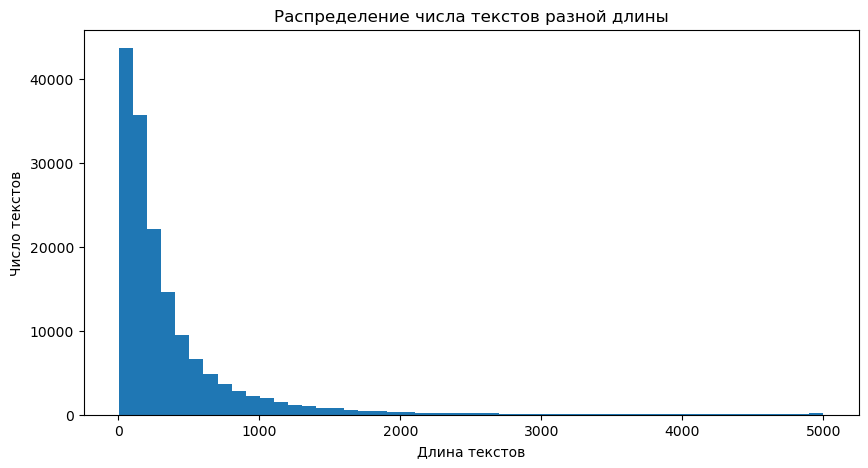

In [11]:
data['length'].plot(kind='hist', bins=50)
plt.xlabel('Text length')
plt.ylabel('Number of texts')
plt.title('Distribution of the number of different length texts')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Now let's find out how toxic and non-toxic comments compare in length.

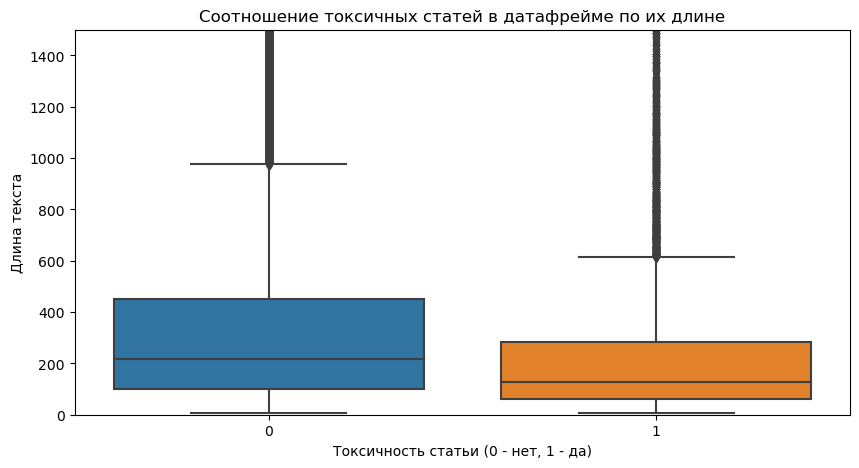

In [12]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='toxic', y='length', data=data)
plt.ylabel('Text length')
plt.ylim(0, 1500)
plt.xlabel('Toxicity of an article (0 - no, 1 - yes)')
plt.title('Ratio of toxic articles in dataframe by their length')
plt.show()

Boxplots show that toxic articles tend to be shorter than non-toxic ones. Well, that's an interesting fact.

### Conclusion after Exploratory Data Analysis:

There are no missing data and no implicit duplicates. One unnecessary column was removed. It was found out that there is an imbalance of classes. This will have to be taken into account in machine learning. In addition, it was found that toxic articles are shorter in length than non-toxic ones.

## Text preprocessing

Let's create a lemmatization class.

In [13]:
lemmatizer = WordNetLemmatizer()

Let's create a function that will accept text and return lemma cleared by regular expressions from unnecessary symbols.

In [14]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemm_and_clean(text):
    text = text.lower()
    text = nltk.word_tokenize(re.sub(r'[^a-zA-Z]', ' ', text))
    text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text]
    return ' '.join(text)

Apply the above function and create an additional column in the data.

In [15]:
data['lemm_text'] = data['text'].progress_apply(lemm_and_clean)

  0%|          | 0/159292 [00:00<?, ?it/s]

Let's take another look at the processed dataset.

In [17]:
data.sample(10)

,text,toxic,length,lemm_text
148638,"-We should just use mainstream sources, -Sammy...",0,50,we should just use mainstream source sammycat
37196,People are using it more now.\n\nI've used VBo...,0,89,people be use it more now i ve use vbox for a ...
136060,18. Removed another external link: this one ha...,0,386,remove another external link this one have no ...
157792,Hi World! Hows it going,0,23,hi world hows it go
6247,"Re: My Behavoir that day \n\nYes, I know it wa...",0,562,re my behavoir that day yes i know it be a bit...
97297,"""== Hello from 168.215.139.83 ==\n\nThis IP is...",0,679,hello from this ip be register to a school and...
100450,"Hey (Hail?), Mr. LC. It's me, Mr. 209.59.32.37...",0,846,hey hail mr lc it s me mr although my proxy ma...
89255,"Hi - Sorry, but I'm afraid that you can't do t...",0,575,hi sorry but i m afraid that you can t do that...
73070,"""::WTF are you an idiot? No really what is you...",1,652,wtf be you an idiot no really what be your iq ...
81129,", 25 March 2011 (UTC)\n\n Disagree. Her parent...",0,711,march utc disagree her parent may have live el...


Now, after processing the text, let's perform a frequency analysis of toxic and non-toxic text.

<function matplotlib.pyplot.show(close=None, block=None)>

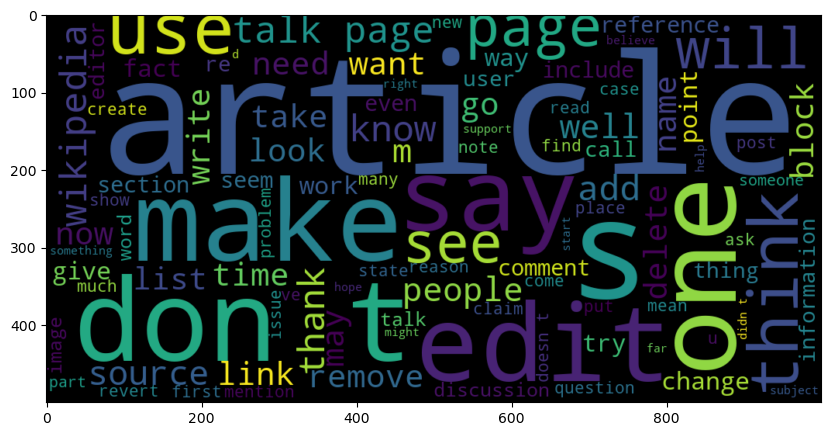

In [33]:
# non-toxic text

plt.figure(figsize=(10, 6))
toxic_neg = ' '.join(data[data['toxic'] == 0]['lemm_text'].values)
toxic_neg_words = WordCloud(width=1000, height=500, max_words=100, min_font_size=5).generate(toxic_neg)
plt.imshow(toxic_neg_words, interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

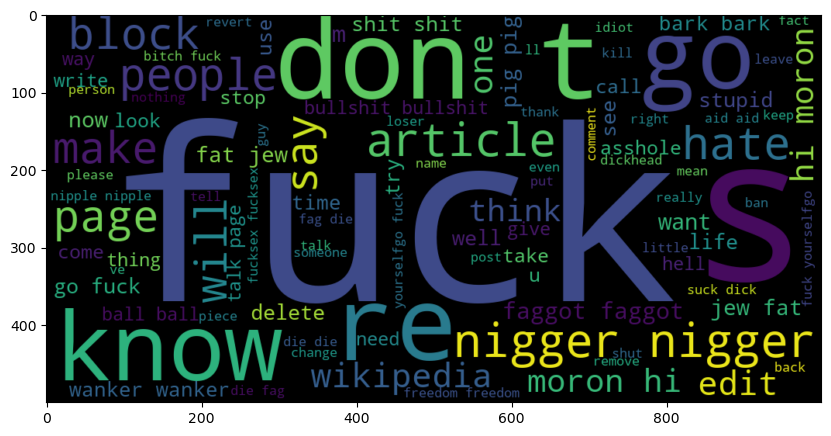

In [34]:
# toxic text

plt.figure(figsize=(10, 6))
toxic_pos = ' '.join(data[data['toxic'] == 1]['lemm_text'].values)
toxic_pos_words = WordCloud(width=1000, height=500, max_words=100, min_font_size=5).generate(toxic_pos)
plt.imshow(toxic_pos_words, interpolation='bilinear')
plt.show

To convert the words into vectors, we will use TF-IDF bag of words. Let's create a counter and specify stop words in it. The last action is necessary to clean the corpus from words that are not meaningful.

In [36]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [37]:
features = data['lemm_text']
target = target = data['toxic']

print(features.shape)
print(target.shape)

(159292,)
(159292,)


Divide the features into training and test samples. Vectorization will be done after selecting the samples in order to avoid data leakage.

In [38]:
features_train,  features_test, target_train, target_test = train_test_split(        
        features, target, test_size=0.25, random_state=12345)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(119469,)
(119469,)
(39823,)
(39823,)


In [39]:
print(f"The ratio of the number of negative classes to the number of positive classes in target_train: \
{np.bincount(target_train)[0] / np.bincount(target_train)[1]}")
print(f"The ratio of the number of negative classes to the number of positive classes in target_test: \
{np.bincount(target_test)[0] / np.bincount(target_test)[1]}")

Отношение кол-ва отрицательных классов к кол-ву положительных в target_train: 8.839318069510789
Отношение кол-ва отрицательных классов к кол-ву положительных в target_test: 8.847428288822947


Now let's vectorize of features with count_tf_idf.

In [40]:
features_train_tf = count_tf_idf.fit_transform(features_train)
print(features_train.shape)

features_test_tf = count_tf_idf.transform(features_test)
print(features_test.shape)

(119469,)
(39823,)


Once the features are processed, we can start machine learning.

## Machine learning

We will search for the best models with GridSearchCV. Let's set cv=5 (5 blocks for cross validation). Let's assign metric F1. I remind that its value should be greater than 0.75.

We will look for the best model among RandomForestClassifier, LogisticRegression, LightGBM.

### RandomForestClassifier

I included the 'class_weight' parameter in this model to evaluate how the model learns with class imbalance.

In [42]:
forest = RandomForestClassifier(random_state=12345)

parameters_forest = { 
    'n_estimators': [100, 150],
    'max_depth' : [15, 20],
    'class_weight': ['balanced', None]
}
    
grid_search_forest = GridSearchCV(estimator=forest, param_grid=parameters_forest, 
                                      scoring='f1', cv=5, n_jobs=-1)
    
grid_search_forest.fit(features_train_tf, target_train)

cv_forest_best = grid_search_forest.best_params_

cv_forest_table = pd.DataFrame(grid_search_forest.cv_results_)

cv_forest_table = cv_forest_table[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score']]

cv_forest_table = cv_forest_table[cv_forest_table['params']==cv_forest_best]

cv_forest_table = cv_forest_table.rename(columns={ 
    'mean_fit_time':'Learning time of the model (с)', 
    'mean_score_time':'Model prediction time (с)',
    'params':'Parameters of the best model',
    'mean_test_score':'F1 for the best model'
})

print('Parameters of RandomForestClassifier:'\
      '\n', cv_forest_table)

Параметры модели RandomForestClassifier:
    Время обучения модели (с)  Время предсказания модели (с)  \
3                  62.373861                       0.574687   

                             Параметры лучшей модели  F1 для лучшей модели  
3  {'class_weight': 'balanced', 'max_depth': 20, ...              0.407764  


### LogisticRegression

Here I have also made provision for training the model with class imbalances.

In [43]:
log_reg = LogisticRegression(random_state=12345)

parameters_log_reg = { 
    'C': [0.5, 1, 10],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter' : [100, 1000],
    'class_weight': ['balanced', None]
}
    
grid_search_log_reg = GridSearchCV(estimator=log_reg, param_grid=parameters_log_reg, 
                                   scoring='f1', cv=5, n_jobs=-1)
    
grid_search_log_reg.fit(features_train_tf, target_train)

cv_log_reg_best = grid_search_log_reg.best_params_

cv_log_reg_table = pd.DataFrame(grid_search_log_reg.cv_results_)

cv_log_reg_table = cv_log_reg_table[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score']]

cv_log_reg_table = cv_log_reg_table[cv_log_reg_table['params']==cv_log_reg_best]

cv_log_reg_table = cv_log_reg_table.rename(columns={ 
    'mean_fit_time':'Learning time of the model (с)', 
    'mean_score_time':'Model prediction time (с)',
    'params':'Parameters of the best model',
    'mean_test_score':'F1 for the best model'
})

print('Parameters of LogisticRegression:'\
      '\n', cv_log_reg_table)

Параметры модели LogisticRegression:
     Время обучения модели (с)  Время предсказания модели (с)  \
30                    2.98975                        0.00928   

                              Параметры лучшей модели  F1 для лучшей модели  
30  {'C': 10, 'class_weight': None, 'max_iter': 10...              0.758886  


### LightGBM

As in the previous cases, I set the parameters search with and without class imbalance in the LightGBM models. I used a limited number of parameters because GridSearchCV takes a very long time to find the best model.

In [45]:
lgbm = lgb.LGBMClassifier(random_state = 12345, objective='binary')

parameters_lgbm = {
    'max_depth': [10, 20],
    'num_leaves': [15, 20],
    'num_iterations': [500, 1000],
    'is_unbalance': [True, False]
}

grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=parameters_lgbm, 
                                scoring='f1', cv=5, n_jobs=-1)

grid_search_lgbm.fit(features_train_tf, target_train)

cv_lgbm_best = grid_search_lgbm.best_params_

cv_lgbm_table = pd.DataFrame(grid_search_lgbm.cv_results_)

cv_lgbm_table = cv_lgbm_table[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score']]

cv_lgbm_table = cv_lgbm_table[cv_lgbm_table['params']==cv_lgbm_best]

cv_lgbm_table = cv_lgbm_table.rename(columns={ 
    'mean_fit_time':'Learning time of the model (с)', 
    'mean_score_time':'Model prediction time (с)',
    'params':'Parameters of the best model',
    'mean_test_score':'F1 for the best model'
})

print('Parameters of LightGBM'\
      '\n', cv_lgbm_table)

Параметры модели LightGBM:
     Время обучения модели (с)  Время предсказания модели (с)  \
14                 104.010445                       7.947947   

                              Параметры лучшей модели  F1 для лучшей модели  
14  {'is_unbalance': False, 'max_depth': 20, 'num_...              0.769763  


Now let's compare all three resulting tables.

In [46]:
cv_forest_table #RandomForestClassifier

,Время обучения модели (с),Время предсказания модели (с),Параметры лучшей модели,F1 для лучшей модели
3,62.373861,0.574687,"{'class_weight': 'balanced', 'max_depth': 20, ...",0.407764


In [47]:
cv_log_reg_table #LogisticRegression

,Время обучения модели (с),Время предсказания модели (с),Параметры лучшей модели,F1 для лучшей модели
30,2.98975,0.00928,"{'C': 10, 'class_weight': None, 'max_iter': 10...",0.758886


In [48]:
cv_lgbm_table #LightGBM

,Время обучения модели (с),Время предсказания модели (с),Параметры лучшей модели,F1 для лучшей модели
14,104.010445,7.947947,"{'is_unbalance': False, 'max_depth': 20, 'num_...",0.769763


Obviously, the LightGBM model showed the best result in terms of metrics. However, its training time is very long compared to the LogisticRegression model. In turn, LogisticRegression is behind LightGBM only by 1%.

### Conclusion after the machine learning stage

Despite the fact that the two models performed well in learning, the LogisticRegression model will be chosen for testing. It is much faster than the others in learning and prediction.

## Testing of the model

Let's test the best logistic regression model and look at its learning and prediction times again.

In [49]:
%%time
best_of_the_best = grid_search_log_reg.best_estimator_.fit(features_train_tf, target_train)

CPU times: user 12 s, sys: 2.73 s, total: 14.8 s
Wall time: 2.38 s


In [50]:
%%time
predictions = best_of_the_best.predict(features_test_tf)

CPU times: user 3.99 ms, sys: 9.23 ms, total: 13.2 ms
Wall time: 42.2 ms


In [51]:
print((f1_score(target_test, predictions)).round(2))

0.79


The choice turned out to be correct. The logistic regression model performed even better in the test.

Now let's check our data using the constant model.

In [52]:
dummy = DummyClassifier(strategy='constant', constant=1)
dummy.fit(features_train_tf, target_train)
dummy_predict = dummy.predict(features_test_tf)
print('F1 for the constant model', (f1_score(target_test, dummy_predict)).round(2))

F1 для константной модели 0.18


The test was successfully passed.

### Conclusion after the testing stage

The LogisticRegression model passed the test perfectly. It showed even better results than on the learning stage (F1=0.79). It also successfully passed the adequacy test.

## Conclusion

We were tasked with developing a machine learning model for the Wikishop store that could detect toxic user edits for items.

Three machine learning models were considered. Machine learning results were controlled by the F1 metric (>0.75). 

LogisticRegtression (F1=0.76) and LightGBM (F1=0.77) were successful in learning and cross-validation. However, the latter model is significantly behind the former model in terms of learning time (104 and 3 seconds, respectively) and prediction time (9 and 0.01 seconds, respectively). Therefore, the LogisticRegression model was chosen for testing.

During the testing stage, the LogisticRegtression model showed a good result (F1=0.79). Also, this model successfully passed the adequacy test.

**Thus, the LogisticRegression model with the hyperparameters presented in the project is recommended for the Wikishop store.**